# CASE STUDY - unsupervised learning


In [41]:
import os
import joblib
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import BayesianGaussianMixture
from sklearn.svm import SVC
import imblearn.pipeline as pl
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, SVMSMOTE
    
plt.style.use('seaborn')
%matplotlib inline

## supress all warnings (not to be used during development)
import warnings
warnings.filterwarnings("ignore")

## Synopsis

  > We are now going to predict customer retention.  There are many models and many transforms to consider.  Use your
    knowledge of pipelines and functions to ensure that your code makes it easy to compare and iterate.  
    
  > Marketing has asked you to make a report on customer retention.  They would like you to come up with information     that can be used to improve current marketing strategy efforts.  The current plan is for marketing at AAVAIL to
    collect more features on subscribers the and they would like to use your report as a proof-of-concept in order to     get buyin for this effort.
  
## Outline

1. Create a churn prediction baseline model
2. Use clustering as part of your prediction pipeline
3. 
4. Run and experiment to see if re-sampling techniques improve your model

## Data

Here we load the data as we have already done.

`aavail-target.csv`

In [3]:
data_dir = os.path.join("..","data")
df = pd.read_csv(os.path.join(data_dir,r"aavail-target.csv"))


## pull out the target and remove uneeded columns
_y = df.pop('is_subscriber')
y = np.zeros(_y.size)
y[_y==0] = 1 
df.drop(columns=['customer_id','customer_name'],inplace=True)
df.head()

,country,age,subscriber_type,num_streams
0,united_states,21,aavail_premium,23
1,singapore,30,aavail_unlimited,12
2,united_states,21,aavail_premium,22
3,united_states,20,aavail_basic,19
4,singapore,21,aavail_premium,23


### Plot age vs num_streams

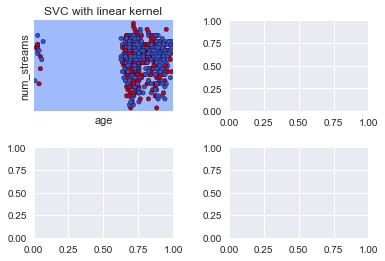

In [8]:
from sklearn import svm

df_orig = pd.read_csv(os.path.join(data_dir,r"aavail-target.csv"))


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

X = df_orig[['age', 'num_streams']]
y = 1-df_orig['is_subscriber']

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
#           svm.LinearSVC(C=C, max_iter=10000),
#           svm.SVC(kernel='rbf', gamma=0.7, C=C),
#           svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)
         )
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
#           'LinearSVC (linear kernel)',
#           'SVC with RBF kernel',
#           'SVC with polynomial (degree 3) kernel'
         )

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X.iloc[:,0], X.iloc[:,1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('age')
    ax.set_ylabel('num_streams')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

### QUESTION 1

Create a stratified train test split of the data

In [25]:
## YOUR CODE HERE

X_train, X_test, y_train, y_test = train_test_split(
    df, y, stratify=y)

### QUESTION 2

Create a baseline model.  We are going to test whether clustering followed by a model improves the results.  The we will test whether re-sampling techniques provide improvements.  Use a pipeline or another method, but create a baseline model given the data. Here is the ColumnTransformer we have used before.

In [10]:
## preprocessing pipeline
numeric_features = ['age', 'num_streams']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = ['country', 'subscriber_type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [68]:
MODELS_DIR = '../models'

rs = np.random.RandomState(1234)

print('Training SVM model...')
param_grid_svm = {
    'svm__C': [0.001, 0.1, 10.0, 20.0],
    'svm__gamma': [0.1, 0.01, 0.001]
}

pipe_svm = Pipeline([('pre', preprocessor),
                     ('svm', SVC(kernel='rbf', class_weight='balanced', random_state=rs))])

time_start = time.time()
grid = GridSearchCV(pipe_svm, param_grid=param_grid_svm, cv=5, iid=False, n_jobs=-1)
grid.fit(X_train, y_train)
joblib.dump(grid, saved_model)
print('train time ', time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
    
svm_best_params = grid.best_params_
print(svm_best_params)

y_pred = grid.predict(X_test)

print('-->'.join(pipe.named_steps.keys()))
print('F1 score: ', round(f1_score(y_test, y_pred), 3))

print()
print('Training RF model...')

param_grid_rf = {
    'rf__n_estimators': [20,50,100,150],
    'rf__max_depth': [4, 5, 6, 7, 8],
    'rf__criterion': ['gini', 'entropy']
}

pipe_rf = Pipeline(steps=[('pre', preprocessor),
                          ('rf', RandomForestClassifier())])

time_start = time.time()
grid = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=5, iid=False, n_jobs=-1)
grid.fit(X_train, y_train)
joblib.dump(grid, saved_model)
print('train time ', time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))

rf_best_params = grid.best_params_
print(rf_best_params)

y_pred = grid.predict(X_test)

print('-->'.join(pipe.named_steps.keys()))
print('F1 score: ', round(f1_score(y_test, y_pred), 3))



Training SVM model...
train time  00:00:00
{'svm__C': 10.0, 'svm__gamma': 0.01}
pre-->svm
F1 score:  0.613

Training RF model...
train time  00:00:10
{'rf__criterion': 'gini', 'rf__max_depth': 4, 'rf__n_estimators': 150}
pre-->svm
F1 score:  0.619


### QUESTION 3

The next part is to create version of the classifier that uses identified clusters.  Here is a class to get you started.  It is a transformer like those that we have been working with.  There is an example of how to use it just below.  In this example 4 clusters were specified and their one-hot encoded versions were appended to the feature matrix.  Now using pipelines and/or functions compare the performance using cluster profiling as part of your matrix to the baseline.  You may compare multiple models and multiple clustering algorithms here.

In [36]:
class KmeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, k=4):
        self.km = KMeans(n_clusters=k,n_init=20)
        
    def transform(self, X, *_):
        labels = self.km.predict(X)
        enc = OneHotEncoder(categories='auto')
        oh_labels = enc.fit_transform(labels.reshape(-1,1))
        oh_labels = oh_labels.todense()
        return(np.hstack((X,oh_labels)))

    def fit(self,X,y=None,*_):
        self.km.fit(X)
        labels = self.km.predict(X)
        self.silhouette_score = round(silhouette_score(X,labels,metric='mahalanobis'),3)
        return(self)

class GmmTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, k=4):
        self.gmm = BayesianGaussianMixture(n_components=k,covariance_type='full',
                                           max_iter=500,n_init=10,warm_start=True)        
    def transform(self, X,*_):
        probs = self.gmm.predict_proba(X) + np.finfo(float).eps
        return(np.hstack((X,probs)))
        
    def fit(self,X,y=None,*_):
        self.gmm.fit(X)
        labels = self.gmm.predict(X)
        self.silhouette_score = round(silhouette_score(X,labels,metric='mahalanobis'),3)
        return(self)
    
## example for GMM  
preprocessor.fit(X_train)
X_train_pre = preprocessor.transform(X_train)    
gt = GmmTransformer(4)
gt.fit(X_train_pre)
X_train_gmm = gt.transform(X_train_pre)
print(X_train_pre.shape)  
print(X_train_gmm.shape)

## example for kmeans
preprocessor.fit(X_train)
X_train_pre = preprocessor.transform(X_train)    
kt = KmeansTransformer(4)
kt.fit(X_train_pre)
X_train_kmeans = kt.transform(X_train_pre)
print(X_train_pre.shape)
print(X_train_kmeans.shape)

(750, 7)
(750, 11)
(750, 7)
(750, 11)


In [69]:
## YOUR CODE HERE

best_params = grid.best_params_

### GMM
print('Evaluating GMM Pipeline...')

pipe_gmm = Pipeline([('pre', preprocessor),
                     ('gmm', GmmTransformer(4)),
#                      ('svm', SVC(kernel='rbf', class_weight='balanced', random_state=rs))
                     ('svm', SVC(C=svm_best_params["svm__C"],gamma=svm_best_params["svm__gamma"]))
                    ])

time_start = time.time()
# grid_gmm = GridSearchCV(pipe_gmm, param_grid=param_grid, cv=5, n_jobs=-1)
pipe_gmm.fit(X_train, y_train)
print('train time ', time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))

y_pred = pipe_gmm.predict(X_test)

print('-->'.join(pipe_gmm.named_steps.keys()))
print('F1 score: ', round(f1_score(y_test, y_pred), 3))

### K-Means
print()
print('Evaluating K-Means Pipeline...')

pipe_kmeans = Pipeline([('pre', preprocessor),
                        ('kmeans', KmeansTransformer(4)),
#                      ('svm', SVC(kernel='rbf', class_weight='balanced', random_state=rs))
                        ('svm', SVC(C=svm_best_params["svm__C"],gamma=svm_best_params["svm__gamma"]))
                       ]) 

time_start = time.time()
# grid_kmeans = GridSearchCV(pipe_kmeans, param_grid=param_grid, cv=5, n_jobs=-1)
pipe_kmeans.fit(X_train, y_train)
print('train time ', time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))

y_pred = pipe_kmeans.predict(X_test)

print('-->'.join(pipe_kmeans.named_steps.keys()))
print('F1 score: ', round(f1_score(y_test, y_pred), 3))

Evaluating GMM Pipeline...
train time  00:00:02
pre-->gmm-->svm
F1 score:  0.613

Evaluating K-Means Pipeline...
train time  00:00:00
pre-->kmeans-->svm
F1 score:  0.619


In [60]:
f1_score(y_test, y_pred)


0.618705035971223

In [109]:
## YOUR CODE HERE

MIN_CLUSTERS = 3
MAX_CLUSTERS = 8

def run_pipeline(classifier_model, clustering_model):

    fscores = []

    for n_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
        
        clusterers = {
            'gmm': GmmTransformer(n_clusters),
            'kmeans': KmeansTransformer(n_clusters)
        }
        
        classifiers = {
            'svm': SVC(C=svm_best_params["svm__C"],gamma=svm_best_params["svm__gamma"]),
            'rf': RandomForestClassifier(n_estimators=rf_best_params['rf__n_estimators'],
                                         max_depth=rf_best_params['rf__max_depth'],
                                         criterion=rf_best_params['rf__criterion'])
        }
        
#         print(clusterers[clustering_model])
#         print(classifiers[classifier_model])
        
        pipe = Pipeline([('pre', preprocessor),
                         (clustering_model, clusterers[clustering_model]),
                         (classifier_model, classifiers[classifier_model])
                        ])

        model = pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        score = round(f1_score(y_test, y_pred), 3)
        fscores.append(score)
        
#         print('n_clusters: ', n_clusters)
#         print('-->'.join(pipe.named_steps.keys()))
#         print('F1 score: ', round(f1_score(y_test, y_pred), 3))
    return fscores
        
classifiers = ['svm', 'rf']
clusterers = ['gmm', 'kmeans']

combos = itertools.product(classifiers, clusterers)

scores = {}
for combo in combos:
    print('Running combo: ', combo[0], ' x ', combo[1])
    scores[combo[0]+'-'+combo[1]] = run_pipeline(combo[0], combo[1])
    
df_results = pd.DataFrame(scores)
df_results['n_clusters'] = [str(i) for i in range(MIN_CLUSTERS, MAX_CLUSTERS+1)]
df_results.set_index('n_clusters', inplace=True)
df_results.head(n=10)

Running combo:  svm  x  gmm
Running combo:  svm  x  kmeans
Running combo:  rf  x  gmm
Running combo:  rf  x  kmeans


,svm-gmm,svm-kmeans,rf-gmm,rf-kmeans
n_clusters,,,,
3,0.613,0.613,0.608,0.603
4,0.613,0.619,0.608,0.609
5,0.602,0.619,0.608,0.609
6,0.602,0.613,0.608,0.609
7,0.602,0.613,0.614,0.600
8,0.613,0.613,0.603,0.603


In [108]:
scores

{'svm-gmm': 0.602, 'svm-kmeans': 0.613, 'rf-gmm': 0.608, 'rf-kmeans': 0.614}

## QUESTION 4

Run an experiment to see if you can you improve on your workflow with the addition of re-sampling techniques?

In [111]:
## YOUR CODE HERE

MIN_CLUSTERS = 3
MAX_CLUSTERS = 8

def run_pipeline(classifier_model, clustering_model):

    fscores = []

    for n_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
        
        clusterers = {
            'gmm': GmmTransformer(n_clusters),
            'kmeans': KmeansTransformer(n_clusters)
        }
        
        classifiers = {
            'svm': SVC(C=svm_best_params["svm__C"],gamma=svm_best_params["svm__gamma"]),
            'rf': RandomForestClassifier(n_estimators=rf_best_params['rf__n_estimators'],
                                         max_depth=rf_best_params['rf__max_depth'],
                                         criterion=rf_best_params['rf__criterion'])
        }
        
#         print(clusterers[clustering_model])
#         print(classifiers[classifier_model])
        
        pipe = pl.Pipeline([('pre', preprocessor),
                         (clustering_model, clusterers[clustering_model]),
                         ('smote', SMOTE(random_state=42)),
                         (classifier_model, classifiers[classifier_model])
                        ])

        model = pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        score = round(f1_score(y_test, y_pred), 3)
        fscores.append(score)
        
#         print('n_clusters: ', n_clusters)
#         print('-->'.join(pipe.named_steps.keys()))
#         print('F1 score: ', round(f1_score(y_test, y_pred), 3))
    return fscores
        
classifiers = ['svm', 'rf']
clusterers = ['gmm', 'kmeans']

combos = itertools.product(classifiers, clusterers)

scores = {}
for combo in combos:
    print('Running combo: ', combo[0], ' x ', combo[1])
    scores[combo[0]+'-'+combo[1]] = run_pipeline(combo[0], combo[1])
    
df_results = pd.DataFrame(scores)
df_results['n_clusters'] = [str(i) for i in range(MIN_CLUSTERS, MAX_CLUSTERS+1)]
df_results.set_index('n_clusters', inplace=True)
df_results.head(n=10)

Running combo:  svm  x  gmm
Running combo:  svm  x  kmeans
Running combo:  rf  x  gmm
Running combo:  rf  x  kmeans


,svm-gmm,svm-kmeans,rf-gmm,rf-kmeans
n_clusters,,,,
3,0.613,0.613,0.617,0.613
4,0.613,0.613,0.613,0.613
5,0.613,0.613,0.617,0.613
6,0.613,0.613,0.613,0.613
7,0.613,0.613,0.613,0.613
8,0.613,0.613,0.613,0.613


## Try Getting Rid of Outliers

In [125]:
outliers = df['age']<0
df.loc[outliers, 'age'] = np.nan

In [134]:
df_orig

,customer_id,is_subscriber,country,age,customer_name,subscriber_type,num_streams
0,1,1,united_states,21,Kasen Todd,aavail_premium,23
1,2,0,singapore,30,Ensley Garza,aavail_unlimited,12
2,3,0,united_states,21,Lillian Carey,aavail_premium,22
3,4,1,united_states,20,Beau Christensen,aavail_basic,19
4,5,1,singapore,21,Ernesto Gibson,aavail_premium,23
...,...,...,...,...,...,...,...
995,996,0,singapore,-46,Peyton Enriquez,aavail_unlimited,14
996,997,1,united_states,23,Amina Manning,aavail_basic,24
997,998,1,united_states,24,Brooks Ventura,aavail_unlimited,17
998,999,1,united_states,39,Nayeli Mathis,aavail_unlimited,16


In [126]:
df

,country,age,subscriber_type,num_streams
0,united_states,21.0,aavail_premium,23
1,singapore,30.0,aavail_unlimited,12
2,united_states,21.0,aavail_premium,22
3,united_states,20.0,aavail_basic,19
4,singapore,21.0,aavail_premium,23
...,...,...,...,...
995,singapore,NaN,aavail_unlimited,14
996,united_states,23.0,aavail_basic,24
997,united_states,24.0,aavail_unlimited,17
998,united_states,39.0,aavail_unlimited,16


In [128]:
df['age'].fillna(df['age'].mean(), inplace=True)
df

,country,age,subscriber_type,num_streams
0,united_states,21.000000,aavail_premium,23
1,singapore,30.000000,aavail_unlimited,12
2,united_states,21.000000,aavail_premium,22
3,united_states,20.000000,aavail_basic,19
4,singapore,21.000000,aavail_premium,23
...,...,...,...,...
995,singapore,26.355984,aavail_unlimited,14
996,united_states,23.000000,aavail_basic,24
997,united_states,24.000000,aavail_unlimited,17
998,united_states,39.000000,aavail_unlimited,16


In [129]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, stratify=y)

In [133]:
## YOUR CODE HERE

MIN_CLUSTERS = 4
MAX_CLUSTERS = 4

def run_pipeline(classifier_model, clustering_model):

    fscores = []

    for n_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
        
        clusterers = {
            'gmm': GmmTransformer(n_clusters),
            'kmeans': KmeansTransformer(n_clusters)
        }
        
        classifiers = {
            'svm': SVC(C=svm_best_params["svm__C"],gamma=svm_best_params["svm__gamma"]),
            'rf': RandomForestClassifier(n_estimators=rf_best_params['rf__n_estimators'],
                                         max_depth=rf_best_params['rf__max_depth'],
                                         criterion=rf_best_params['rf__criterion'])
        }
        
#         print(clusterers[clustering_model])
#         print(classifiers[classifier_model])
        
        pipe = pl.Pipeline([('pre', preprocessor),
                         (clustering_model, clusterers[clustering_model]),
                         ('smote', SMOTE(random_state=42)),
                         (classifier_model, classifiers[classifier_model])
                        ])

        model = pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        score = round(f1_score(y_test, y_pred), 3)
        fscores.append(score)
        
#         print('n_clusters: ', n_clusters)
#         print('-->'.join(pipe.named_steps.keys()))
#         print('F1 score: ', round(f1_score(y_test, y_pred), 3))
    return fscores
        
classifiers = ['svm', 'rf']
clusterers = ['gmm', 'kmeans']

combos = itertools.product(classifiers, clusterers)

scores = {}
for combo in combos:
    print('Running combo: ', combo[0], ' x ', combo[1])
    scores[combo[0]+'-'+combo[1]] = run_pipeline(combo[0], combo[1])
    
df_results = pd.DataFrame(scores)
df_results['n_clusters'] = [str(i) for i in range(MIN_CLUSTERS, MAX_CLUSTERS+1)]
df_results.set_index('n_clusters', inplace=True)
df_results.head(n=10)

Running combo:  svm  x  gmm
Running combo:  svm  x  kmeans
Running combo:  rf  x  gmm
Running combo:  rf  x  kmeans


,svm-gmm,svm-kmeans,rf-gmm,rf-kmeans
n_clusters,,,,
4,0.623,0.623,0.631,0.623
